# Predicting an insurance premium

In this notebook, our goal is to predict the cheapest insurance price that will be offered by a range of insurance providers for a given quote's background information.

# Data Cleaning

### Import data and packages

In [26]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [135]:
# Import the data and set the 33 column to string to avoid memory issues

# Set the path accordingly
df = pd.read_csv("df_prices.csv", dtype={33: str})

In [136]:
# Understand basic information about the dataframe
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385025 entries, 0 to 385024
Data columns (total 67 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   ID                                             385025 non-null  int64  
 1   QUOTEID                                        385025 non-null  int64  
 2   Insurer                                        385025 non-null  object 
 3   Product                                        385025 non-null  object 
 4   PaymentMethod                                  385025 non-null  object 
 5   PaymentFrequency                               385025 non-null  object 
 6   TotalCostPerPaymentPeriod                      385025 non-null  float64
 7   TotalPremiumIncludingIPT                       385025 non-null  float64
 8   TotalPremiumExcludingIPT                       385025 non-null  float64
 9   AdministrationChargeIncludingIPT     

### Missing and duplicated observations

In [137]:
# Drop duplicate observations in terms of ID and QUOTEID
obs_before = len(df)
df = df.drop_duplicates(subset=['ID', 'QUOTEID'])
obs_after = len(df)
print(f"The number of duplicate observations that were dropped is {obs_before-obs_after}")


The number of duplicate observations that were dropped is 0


In [138]:
# Many columns have a unique value so we may drop these columns
# However, it is valuable to have a look at the values of some of these columns such as (content cover)
# These features might still help us understand what data we are working with and what potential
# Predictors of price may be

columns_drop = []

for col in df.columns:
    if df[col].nunique() == 1:
        columns_drop.append(col)
    elif df[col].nunique() == 2 and df[col].isna().any():
        columns_drop.append(col)


# Generate a metadataframe to store information about what the subsection of what we are working with
df_metadata = df[columns_drop].drop_duplicates()

# Dropping the features without any variation for modelling
df = df.drop(columns=columns_drop)



In [139]:
df_metadata_long = df_metadata.melt(var_name="Feature", value_name="Value")
df_metadata_long

,Feature,Value
0,Product,Home Insurance
1,AdministrationChargeIncludingIPT,39.6
2,AdministrationChargeExcludingIPT,36
3,HomeEmergencyPremiumIncludingIPT,0
4,OriginalHomeEmergencyPremiumExcludingIPT,0
5,HomeEmergencyPremiumExcludingIPT,0
6,LegalExpensesPremiumIncludingIPT,0
7,OriginalLegalExpensesPremiumExcludingIPT,0
8,LegalExpensesPremiumExcludingIPT,0
9,OriginalBuildingsCoverGrossExcludingIPT,0


In [140]:
# Identify the columns which are completely missing
col_missing = []

for col in df.columns:
    if df[col].notna().sum() == 0:
        col_missing.append(col)

# Identify the columns with missing values
col_with_missing_values = []

for col in df.columns:
    if df[col].isna().sum() > 0:
        col_with_missing_values.append(col)


print(f"The number of columns which are completely missing is: {len(col_missing)}, "
      f"and there are {len(col_with_missing_values)} columns with missing values out of {len(df.columns)}.")

The number of columns which are completely missing is: 0, and there are 0 columns with missing values out of 23.


### Duplicated features

In [141]:
# Check if any of the features hold duplicate information
from itertools import combinations

def find_duplicated_columns(df):
    duplicate_cols = []
    for col1, col2 in combinations(df.columns, 2):
        if df[col1].equals(df[col2]):
            duplicate_cols.append(col1)
            duplicate_cols.append(col2)
    return duplicate_cols

duplicate_cols = set(find_duplicated_columns(df))
print(duplicate_cols)

{'HouseholdInsurancePremiumExcludingIPT', 'ContentsCoverGrossExcludingIPT', 'OriginalHouseholdInsurancePremiumExcludingIPT', 'OriginalContentsCoverGrossExcludingIPT'}


In [142]:
df["duplicate_check_gross"] = df["ContentsCoverGrossExcludingIPT"] - df["OriginalContentsCoverGrossExcludingIPT"]
total = df["duplicate_check_gross"].sum()

print(f"The number of values that are different is: {total}")

The number of values that are different is: 0.0


In [143]:
df["duplicate_check_premium"] = df["HouseholdInsurancePremiumExcludingIPT"] - df["OriginalHouseholdInsurancePremiumExcludingIPT"]
total = df["duplicate_check_premium"].sum()

print(f"The number of values that are different is: {total}")

The number of values that are different is: 0.0


In [144]:
df["duplicate_check_cross"] = df["HouseholdInsurancePremiumExcludingIPT"] - df["OriginalContentsCoverGrossExcludingIPT"]
total = df["duplicate_check_cross"].sum()

print(f"The number of values that are different is: {total}")

The number of values that are different is: 0.0


In [145]:
# Three of the four columns identified as having duplicates may be dropped

# Implementing the drop (and removing the check variables)
col_drop = ["OriginalContentsCoverGrossExcludingIPT", "HouseholdInsurancePremiumExcludingIPT", 
            "OriginalHouseholdInsurancePremiumExcludingIPT", "duplicate_check_premium",
            "duplicate_check_gross", "duplicate_check_cross"
           ]
df = df.drop(columns= col_drop)

# Renaming the remaining variable
df = df.rename(columns= {"ContentsCoverGrossExcludingIPT": "Cover_and_premium_dup"})

### Outlier detection and distributions

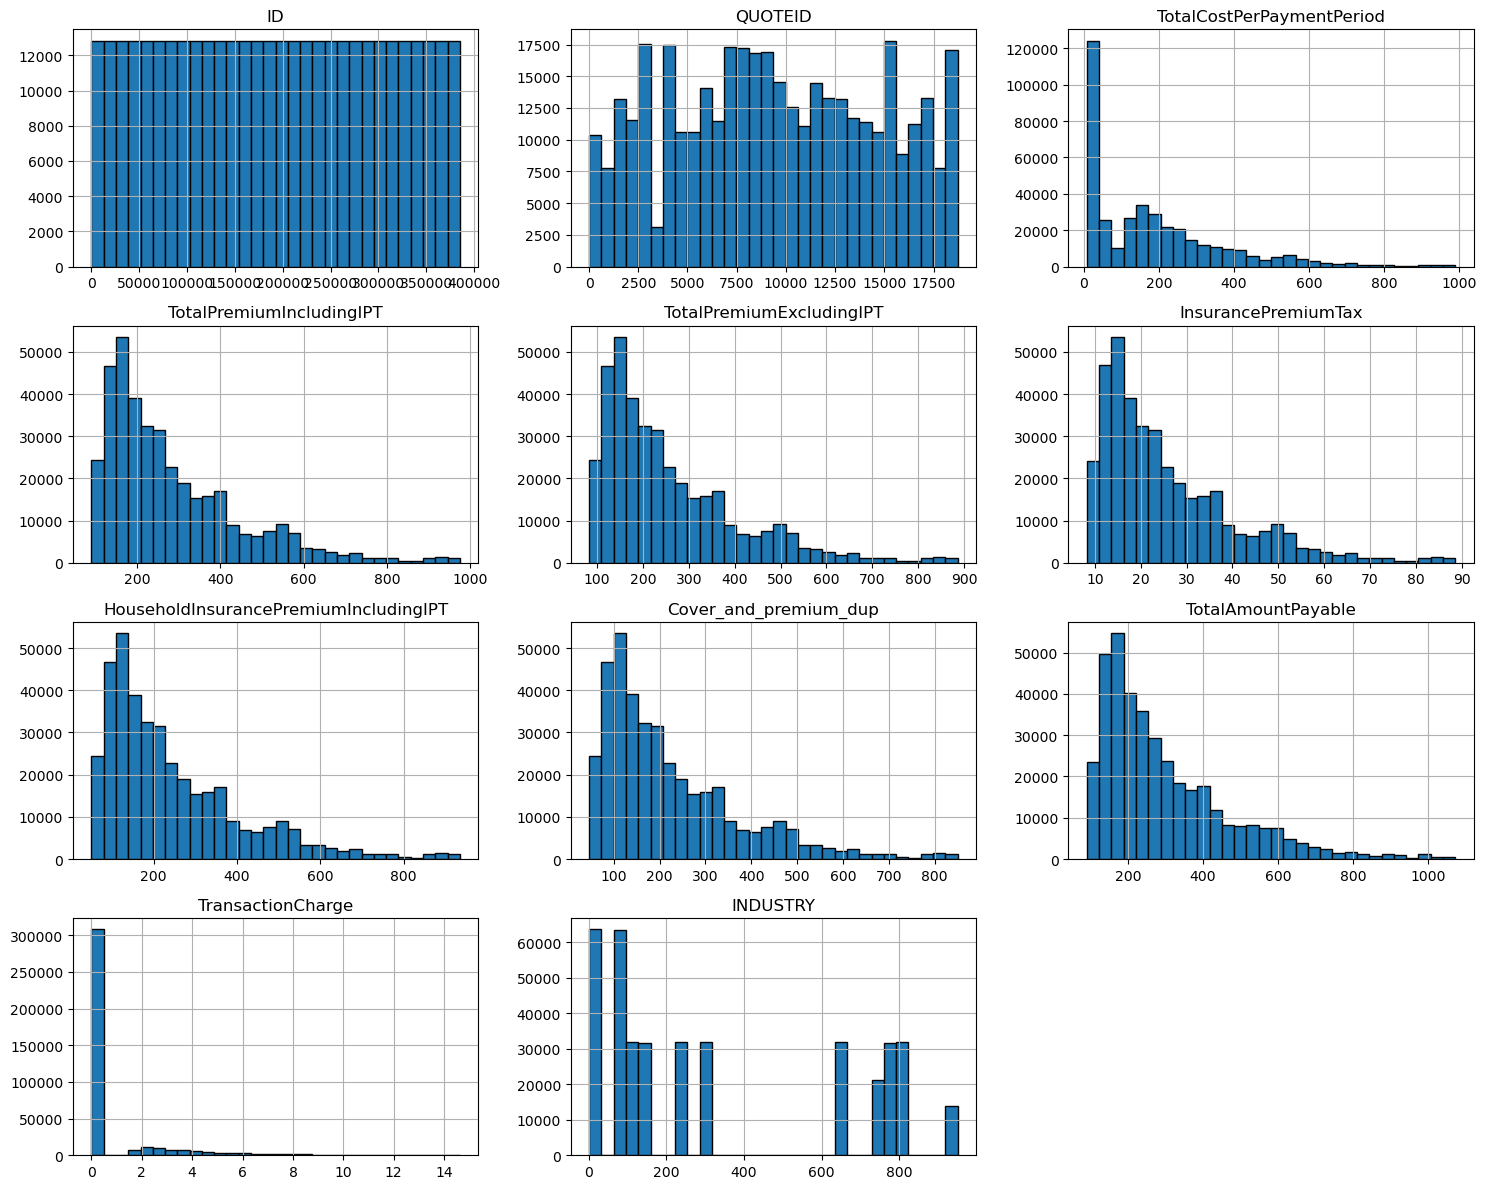

In [146]:
# Visualising distributions and potential outlier values

# Plot histograms
df.hist(bins=30, figsize=(15, 12), edgecolor='black')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

# Setting the variable types

In [147]:
# Checking for consistency across data types and unique values of the features

for col in df.columns:
    print()
    print(f"This column is: {col}")
    print(df[col].unique()[:10])
    print(df[col].dtype)


This column is: ID
[ 1  2  3  4  5  6  7  8  9 10]
int64

This column is: QUOTEID
[ 1  2  3  4  5  6  7  8 10  9]
int64

This column is: Insurer
['A' 'B' 'C' 'D' 'E' 'F' 'G']
object

This column is: PaymentMethod
['DirectDebit' 'CreditCard' 'DebitCard']
object

This column is: PaymentFrequency
['Annual' 'Monthly2MonthsFree' 'Monthly']
object

This column is: TotalCostPerPaymentPeriod
[114.92 116.64  12.64  10.53 269.34 273.38  29.63  24.69 283.9  288.16]
float64

This column is: TotalPremiumIncludingIPT
[114.92 269.34 283.9  493.75 101.09 269.35 283.91 493.79 145.34 292.34]
float64

This column is: TotalPremiumExcludingIPT
[104.47 244.85 258.09 448.86  91.9  244.86 258.1  448.9  132.13 265.76]
float64

This column is: InsurancePremiumTax
[10.45 24.49 25.81 44.89  9.19 13.21 26.58 35.9  48.32 10.95]
float64

This column is: HouseholdInsurancePremiumIncludingIPT
[ 75.32 229.74 244.3  454.15  61.49 229.75 244.31 454.19 105.74 252.74]
float64

This column is: Cover_and_premium_dup
[ 68.47

In [148]:
# Fix data types

# Map the string values of bedrooms to integers
mapping = {'One': 1, 'Three': 3, 'Five':5}
df["NUMBEDROOMS"] = df["NUMBEDROOMS"].map(mapping)

# Convert the Date of Birth column to datetime
#DOB '01/01/1976'
df["DOB"] = pd.to_datetime(df["DOB"])

# Calculate the age
from datetime import datetime
current_date = datetime.today()
df["days_since_DOB"] = current_date - df["DOB"]
df["Age"] = (df["days_since_DOB"].dt.days // 365.25).astype(int)
# Drop temporary columns
df = df.drop(columns=["days_since_DOB", "DOB"])

# Convert boolean features into dummies
for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

# Convert industry to an object since there is no ordering to its categories
df["INDUSTRY"] = df["INDUSTRY"].astype(str)

# Choosing the modelling approach

Text(0, 0.5, 'Frequency')

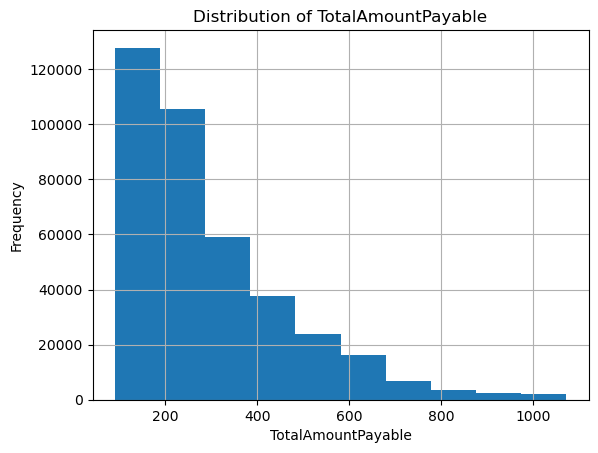

In [150]:
# Plotting the distribution of the outcome might be helpful in understand the prediction task better

df["TotalAmountPayable"].hist()

plt.title("Distribution of TotalAmountPayable")
plt.xlabel("TotalAmountPayable")
plt.ylabel("Frequency")

# This suggests a right skew in the distribution of the outcome variable, a linear model might not be appropriate

Text(0, 0.5, 'Frequency')

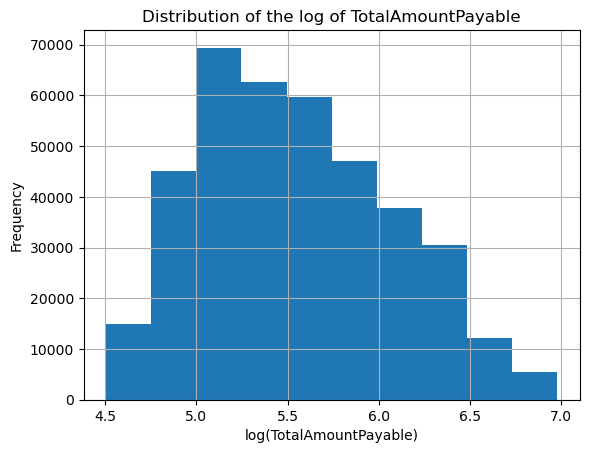

In [152]:
# A log transformation appears to be helpful in re-establishing normality in the outcome
df["log_TotalAmountPayable"] = np.log(df["TotalAmountPayable"])
df["log_TotalAmountPayable"].hist()


plt.title("Distribution of the log of TotalAmountPayable")
plt.xlabel("log(TotalAmountPayable)")
plt.ylabel("Frequency")


# A log transformation may help a linear model in predicting the outcome

In [153]:
# I check whether maybe it would be worth it to predict subcomponents of the TotalAmountPayable
# And using these as features to predict the outcome of interest

# Selecting relevant features
component_features = [
    "TotalCostPerPaymentPeriod", 
    "TotalPremiumIncludingIPT", 
    "TotalPremiumExcludingIPT", 
    "InsurancePremiumTax", 
    "HouseholdInsurancePremiumIncludingIPT", 
    "TransactionCharge", 
    "Cover_and_premium_dup", 
    "TotalAmountPayable"
]

# Compute correlation matrix
corr_matrix = df[component_features].corr()

# Display correlation of components with TotalAmountPayable
print("Correlation of components with TotalAmountPayable:")
print(corr_matrix["TotalAmountPayable"].sort_values(ascending=False))

# Which suggests that a potential approach could be in predicting intermediary components making up the TotalAmountPayable
# By reverse engineering its formula

Correlation of components with TotalAmountPayable:
TotalAmountPayable                       1.000000
HouseholdInsurancePremiumIncludingIPT    0.996005
TotalPremiumIncludingIPT                 0.996005
TotalPremiumExcludingIPT                 0.996005
Cover_and_premium_dup                    0.996005
InsurancePremiumTax                      0.996005
TotalCostPerPaymentPeriod                0.514452
TransactionCharge                        0.216195
Name: TotalAmountPayable, dtype: float64


In [154]:
# Here I attempt to investigate if predicting the mean price and it's spread could be a helpful input feature to predict the lowest price

# Calculate mean and std
df["mean"] = df.groupby("QUOTEID")["TotalAmountPayable"].transform("mean")
df["std"] = df.groupby("QUOTEID")["TotalAmountPayable"].transform("std")


# Identify the cheapest
df["CheapestQuote"] = df.groupby("QUOTEID")["TotalAmountPayable"].transform("min")

# Toy dataframe

df_toy = df[["CheapestQuote","mean", "std"]].copy()
df_toy = df_toy.drop_duplicates()

# drop means and std form original dataframe
df = df.drop(columns= ["mean", "std"])

# Compute correlation matrix
corr_matrix = df_toy.corr()

# Display correlation of components with TotalAmountPayable
print("Correlation of components with TotalAmountPayable:")
print(corr_matrix["CheapestQuote"].sort_values(ascending=False))

# The correlations are relatively low, corroborated by the scatter plots

Correlation of components with TotalAmountPayable:
CheapestQuote    1.000000
mean             0.572624
std              0.167702
Name: CheapestQuote, dtype: float64


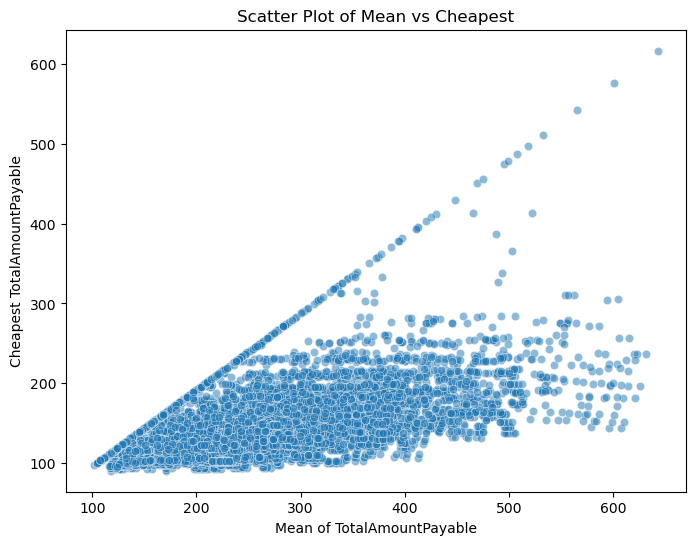

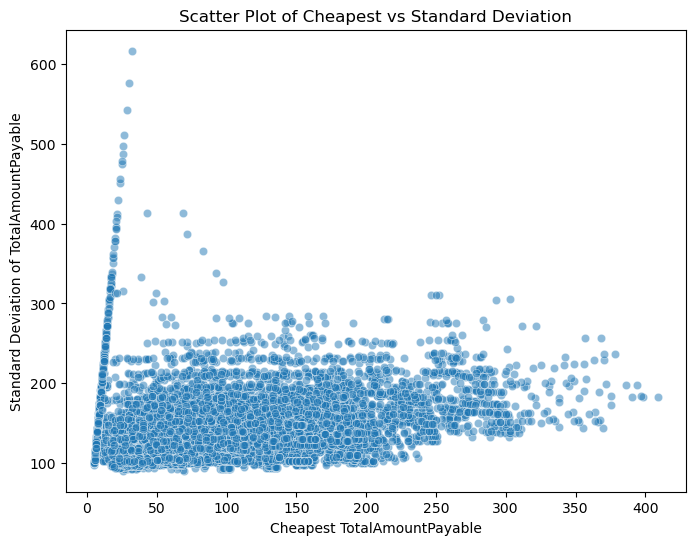

In [155]:
import seaborn as sns

# Scatter plot of Mean vs Cheapest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_toy["mean"], y=df_toy["CheapestQuote"], alpha=0.5)
plt.xlabel("Mean of TotalAmountPayable")
plt.ylabel("Cheapest TotalAmountPayable")
plt.title("Scatter Plot of Mean vs Cheapest")
plt.show()

# Scatter plot of Cheapest vs Standard Deviation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_toy["std"], y=df_toy["CheapestQuote"], alpha=0.5)
plt.xlabel("Cheapest TotalAmountPayable")
plt.ylabel("Standard Deviation of TotalAmountPayable")
plt.title("Scatter Plot of Cheapest vs Standard Deviation")
plt.show()

# Preprocessing steps for modelling

I have decided to run a Ridge regression (because one-hot encoding will create many dummies), and a Random Forests model, as well as a CatBoost model which might be appropriate given that most of the input features are categorical.

Tree-based approaches do not typically require transformations on the data but the Ridge regression assumes that the outcome variable is normally distributed, as such it will benefit from a log transformation of the outcome.

Evaluation metrics for hyperparameter tuning will be MSE in the log space (prevents issues related to the right skew) and after returning the outcome and predictions to their normal scale, alternative metrics will be used such as MAE, MAPE, RMSE

In [47]:
# Focus on relevant columns for prediction

columns_drop = [
    "Insurer", "PaymentMethod", "PaymentFrequency", 
    "TotalCostPerPaymentPeriod", "TotalPremiumIncludingIPT", 
    "TotalPremiumExcludingIPT", "InsurancePremiumTax",
    "HouseholdInsurancePremiumIncludingIPT", "Cover_and_premium_dup", 
    "TransactionCharge", "TotalAmountPayable", "log_TotalAmountPayable"
               ]

df = df.drop(columns=columns_drop)

# Select the cheapest quote
df = df.drop_duplicates(subset= ["QUOTEID"])

In [48]:
# Calculate the log of the outcome

df["log_CheapestQuote"] = np.log(df["CheapestQuote"])

# Drop unecessary columns
df = df.drop(columns=["QUOTEID", "CheapestQuote"])

In [49]:
# One-hot encoding for unordered categories
categories = [col for col in df.columns if df[col].dtype == "O"]
df_dummies = pd.get_dummies(df, columns=categories, drop_first=True, prefix=categories, prefix_sep="_dummy")

# Ensure that the dummies are integers and not boolean values
bool_columns = [col for col in df_dummies.columns if df_dummies[col].dtype == "bool"]
df_dummies[bool_columns] = df_dummies[bool_columns].astype(int)


# Ridge regression

In [115]:
# Import necessary packages

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform

# Extract Features
X = df_dummies.drop(columns=["ID", "log_CheapestQuote"])
# Extract outcome variable
y = df_dummies["log_CheapestQuote"]

# Split the data in train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Identifying the ordinal features to scale
list_to_scale = ["NUMBEDROOMS", "Age"]

# Preprocessing step - This pipeline is necessary to ensure that there is no data leakage in the cross validation process
prep = ColumnTransformer(transformers=[("continuous_features", StandardScaler(), 
                                        list_to_scale)], remainder="passthrough")

# Define the pipeline
pipeline_ridge = Pipeline([
    ('scaler', prep),
    ('model', Ridge())
])


# Define the parameter space to search over
parameter_space_ridge = {
    'model__alpha': loguniform(1e-4, 10) 
}


# Define the cross validation hyperparameter tuning process
k_folds = KFold(n_splits=5, shuffle=True, random_state=1)

random_search = RandomizedSearchCV(
    pipeline_ridge, 
    param_distributions=parameter_space_ridge, 
    n_iter=80,  
    cv=k_folds, 
    scoring='neg_mean_squared_error',
    n_jobs=6, 
    verbose=1, 
    random_state=1
)

# Optimise
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/opt/anaconda3/envs/Urban/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('scaler',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('continuous_features',
                                                                               StandardScaler(),
                                                                               ['NUMBEDROOMS',
                                                                                'Age'])])),
                                             ('model', Ridge())]),
                   n_iter=80, n_jobs=6,
                   param_distributions={'model__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x166293a90>},
                   random_state=1, scoring='neg_mean_squared_error', verbose=1)

In [116]:
# Extract the best model and best hyperparameter
best_model_ridge = random_search.best_estimator_
best_params = random_search.best_params_['model__alpha']

In [117]:
best_params

0.08841535286150216

In [122]:
# Let's check the cross validation result to be able to compare them to the test set evaluation scores
# Any discrepancy could suggest under or overfitting

cv_scores_ridge = random_search.cv_results_

# Mean and standard deviation of MSE across folds
mean_cv = -cv_scores_ridge['mean_test_score'] 
std_cv = cv_scores_ridge['std_test_score']

print(f"The mean CV MSE is {round(np.mean(mean_cv), 5)} ± {round(np.std(std_cv), 5)}")

The mean CV MSE is 0.00648 ± 0.0


In [123]:
# Predict on the test set
y_pred = best_model_ridge.predict(X_test)

In [124]:
# Evaluate the model on the test set
mse_result = mean_squared_error(y_test, y_pred)
print(f"The MSE of the Ridge model on the test set is: {mse_result}")

The MSE of the Ridge model on the test set is: 0.006373738957666326


In [120]:
from sklearn.metrics import mean_absolute_percentage_error

# Evaluate the model on the original scale of the outcome (reverse transformation)
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Evaluate the model on the test set on original scale
mse_result_original = mean_squared_error(y_test_original, y_pred_original)
rmse_result_original = np.sqrt(mse_result_original)
# Compute MAPE
mape_result = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"The MSE of the Ridge model on the original scale of the test set is: {round(mse_result_original, 2)}")
print(f"The RMSE of the Ridge model on the original scale of the test set is: {round(rmse_result_original, 2)}")
print(f"The MAPE of the Ridge model on the original scale of the test set is: {round(mape_result, 2)}%")


The MSE of the Ridge model on the original scale of the test set is: 360.48
The RMSE of the Ridge model on the original scale of the test set is: 18.99
The MAPE of the Ridge model on the original scale of the test set is: 5.45%


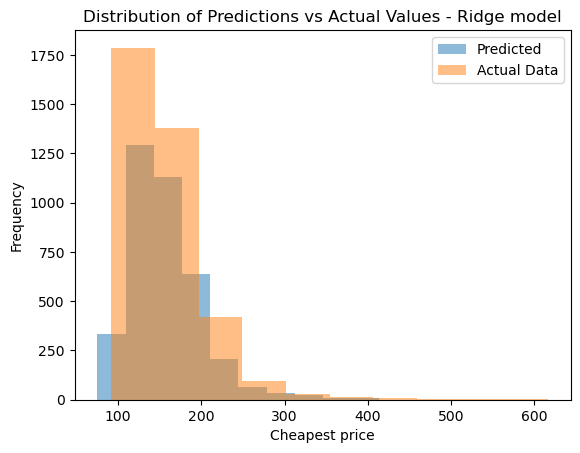

In [121]:
# Plot the distribution of predicted values

plt.hist(np.exp(y_pred), alpha=0.5, label="Predicted")
plt.hist(np.exp(y_test), alpha=0.5, label= "Actual Data")

plt.title("Distribution of Predictions vs Actual Values - Ridge model")
plt.xlabel("Cheapest price")
plt.ylabel("Frequency")

plt.legend()

# Random Forests model

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error



# Initiate a pipeline
pipeline_RF = Pipeline([
    ('model', RandomForestRegressor(bootstrap=True, random_state=1))
])

# Define the parameter space to search over

parameter_space_RF = {"model__n_estimators": list(range(10, 600)), "model__max_depth": list(range(1, 40)),
                "model__min_samples_split": list(range(2,40)), "model__min_samples_leaf": list(range(1,10)),
                "model__max_features": [0.1, 0.2, 0.3, 0.5, 0.6, "sqrt"], "model__max_samples": [0.6, 0.7, 0.8, 0.9, 1.0],
                }


# Define the cross validation hyperparameter tuning process
k_folds = KFold(n_splits=5, shuffle=True, random_state=1)

random_search = RandomizedSearchCV(
    pipeline_RF, 
    param_distributions=parameter_space_RF, 
    n_iter=40,  
    cv=k_folds, 
    scoring='neg_mean_squared_error',
    n_jobs=2, 
    verbose=1, 
    random_state=1
)

# Optimise over the hyperparameter space
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/envs/Urban/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor(random_state=1))]),
                   n_iter=40, n_jobs=2,
                   param_distributions={'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'model__max_features': [0.1, 0.2, 0.3,
                                                                0.5, 0.6,
                                                                'sqrt'],
                                        'model__m....8,
                                                               0.9, 1.0],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, ...],
                                        'model__n_estimators': [10, 11, 12, 13,
                                                                14, 15, 16, 17,
                                                                18, 19, 20, 21,
                                                                22, 23, 24, 25,
                                                                26, 27, 28, 29,
                                                                30, 31, 32, 33,
                                                                34, 35, 36, 37,
                                                                38, 39, ...]},
                   random_state=1, scoring='neg_mean_squared_error', verbose=1)

In [126]:
# Extract the best model and best hyperparameter
best_model_RF = random_search.best_estimator_
best_para_RF = random_search.best_params_

In [128]:
best_para_RF

{'model__n_estimators': 354,
 'model__min_samples_split': 6,
 'model__min_samples_leaf': 3,
 'model__max_samples': 1.0,
 'model__max_features': 0.3,
 'model__max_depth': 35}

In [129]:
# Let's check the cross validation result to be able to compare them to the test set evaluation scores
# Any discrepancy could suggest under or overfitting

cv_scores_RF = random_search.cv_results_

# Mean and standard deviation of MSE across folds
mean_cv = -cv_scores_RF['mean_test_score'] 
std_cv = cv_scores_RF['std_test_score']

print(f"The mean CV MSE is {round(np.mean(mean_cv), 5)} ± {round(np.std(std_cv), 5)}")

The mean CV MSE is 0.01295 ± 0.00048


In [130]:
# Predict on the test set
y_pred = best_model_RF.predict(X_test)

In [131]:
# Evaluate the model on the test set
mse_result = mean_squared_error(y_test, y_pred)
print(f"The MSE of the RF model is: {mse_result}")

The MSE of the RF model is: 0.0011746786036204787


In [132]:
from sklearn.metrics import mean_absolute_percentage_error

# Evaluate the model on the original scale of the outcome (reverse transformation)
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Evaluate the model on the test set on original scale
mse_result_original = mean_squared_error(y_test_original, y_pred_original)
rmse_result_original = np.sqrt(mse_result_original)
# Compute MAPE
mape_result = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"The MSE of the CatBoost model on the original scale of the test set is: {round(mse_result_original, 2)}")
print(f"The RMSE of the CatBoost model on the original scale of the test set is: {round(rmse_result_original, 2)}")
print(f"The MAPE of the CatBoost model on the original scale of the test set is: {round(mape_result, 2)}%")

The MSE of the CatBoost model on the original scale of the test set is: 68.08
The RMSE of the CatBoost model on the original scale of the test set is: 8.25
The MAPE of the CatBoost model on the original scale of the test set is: 2.47%


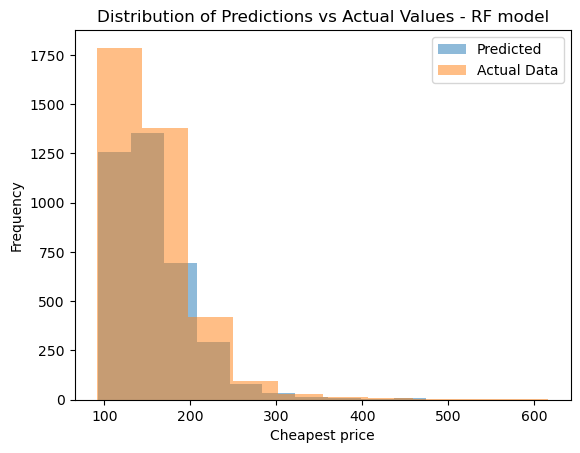

In [133]:
# Plot the distribution of predicted values

plt.hist(np.exp(y_pred), alpha=0.5, label="Predicted")
plt.hist(np.exp(y_test), alpha=0.5, label= "Actual Data")

plt.title("Distribution of Predictions vs Actual Values - RF model")
plt.xlabel("Cheapest price")
plt.ylabel("Frequency")

plt.legend()

# CatBoost model

In [78]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Define categorical features
categorical_features = [col for col in df.columns if df[col].dtype == "O"]

# Extract Features
X = df.drop(columns=["ID", "log_CheapestQuote"])
# Extract outcome variable
y = df["log_CheapestQuote"]

# Split the data in train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define model
catboost = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    verbose=0,  
    cat_features=categorical_features,
    early_stopping_rounds=70,  # have early stopping to prevent overfitting
    random_state=1
)

# Initiate a pipeline
pipeline_cat = Pipeline([
    ('model', catboost)
])

# Define the parameter space to search over
parameter_space_cat = {
    "model__depth": list(range(4, 15)),  
    "model__learning_rate": np.arange(0.02, 0.4, 0.05).tolist(),  
    "model__l2_leaf_reg": list(range(1, 10)),  
    "model__subsample": np.arange(0.7, 1.0, 0.1).tolist(), 
    "model__random_strength": list(range(1, 10)), 
}


# Define the cross validation hyperparameter tuning process
k_folds = KFold(n_splits=5, shuffle=True, random_state=1)

random_search = RandomizedSearchCV(
    pipeline_cat, 
    param_distributions=parameter_space_cat, 
    n_iter=40,  
    cv=k_folds, 
    scoring='neg_mean_squared_error',
    n_jobs=2, 
    verbose=1, 
    random_state=1
)


# Optimise over the hyperparameter space
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/envs/Urban/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              <catboost.core.CatBoostRegressor object at 0x1668af710>)]),
                   n_iter=40, n_jobs=2,
                   param_distributions={'model__depth': [4, 5, 6, 7, 8, 9, 10,
                                                         11, 12, 13, 14],
                                        'model__l2_leaf_reg': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9],
                                        'model__learning_rate': [0.02, 0.07,
                                                                 0.12000000000000001,
                                                                 0.17, 0.22,
                                                                 0.27, 0.32,
                                                                 0.37],
                                        'model__random_strength': [1, 2, 3, 4,
                                                                   5, 6, 7, 8,
                                                                   9],
                                        'model__subsample': [0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999,
                                                             0.9999999999999999]},
                   random_state=1, scoring='neg_mean_squared_error', verbose=1)

In [79]:
# Extract the best model and best hyperparameter
best_model_cat = random_search.best_estimator_
best_para_cat = random_search.best_params_

In [85]:
best_para_cat

{'model__subsample': 0.7999999999999999,
 'model__random_strength': 5,
 'model__learning_rate': 0.22,
 'model__l2_leaf_reg': 9,
 'model__depth': 11}

In [96]:
# Let's check the cross validation result to be able to compare them to the test set evaluation scores
# Any discrepancy could suggest under or overfitting

cv_scores_cat = random_search.cv_results_

# Mean and standard deviation of MSE across folds
mean_cv = -cv_scores_cat['mean_test_score'] 
std_cv = cv_scores_cat['std_test_score']

print(f"The mean CV MSE is {round(np.mean(mean_cv), 5)} ± {round(np.std(std_cv), 5)}")

The mean CV MSE is 0.0007 ± 3e-05


In [81]:
# Predict on the test set
y_pred = best_model_cat.predict(X_test)

In [97]:
# Evaluate the model on the test set
mse_result = mean_squared_error(y_test, y_pred)
print(f"The MSE of the CatBoost model on the test set is: {mse_result}")

The MSE of the CatBoost model on the test set is: 0.00029793315127675036


In [106]:
from sklearn.metrics import mean_absolute_percentage_error


# Evaluate the model on the original scale of the outcome (reverse transformation)
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Evaluate the model on the test set on original scale
mse_result_original = mean_squared_error(y_test_original, y_pred_original)
rmse_result_original = np.sqrt(mse_result_original)
# Compute MAPE
mape_result = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"The MSE of the CatBoost model on the original scale of the test set is: {round(mse_result_original, 2)}")
print(f"The RMSE of the CatBoost model on the original scale of the test set is: {round(rmse_result_original, 2)}")
print(f"The MAPE of the CatBoost model on the original scale of the test set is: {round(mape_result, 2)}%")

The MSE of the CatBoost model on the original scale on the test set is: 10.05
The RMSE of the CatBoost model on the original scale on the test set is: 3.17
The MAPE of the CatBoost model on the original scale on the test set is: 1.13%


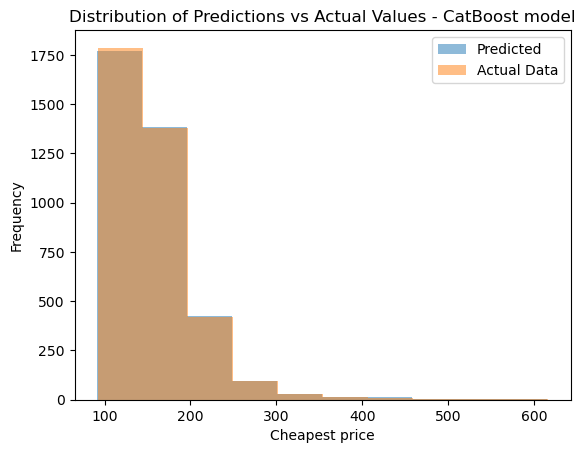

In [113]:
# Plot the distribution of predicted values

plt.hist(np.exp(y_pred), alpha=0.5, label="Predicted")
plt.hist(np.exp(y_test), alpha=0.5, label= "Actual Data")

plt.title("Distribution of Predictions vs Actual Values - CatBoost model")
plt.xlabel("Cheapest price")
plt.ylabel("Frequency")

plt.legend()